In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import chi2_contingency

In [20]:
# data = pd.read_csv('../data/updated_data.csv')
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

train_df = pd.concat([X_train,y_train], axis=1)

In [21]:
# data_vars = data.columns
train_vars = train_df.columns

# print(f"Dataset variables: {data_vars}")
print(f"Train dataset variables: {train_vars}")

Train dataset variables: Index(['Domestic', 'TripReason', 'Vehicle', 'LogPrice', 'LogLeadTime',
       'TimeOfDay', 'From_Encoded', 'To_Encoded', 'Route_Encoded', 'Cancel'],
      dtype='object')


In [22]:
# Binary / Categorical Variables (The OHE columns)
cat_vars = [
    'Domestic', 'TripReason', 'Vehicle', 'TimeOfDay',
    'From_Encoded', 'To_Encoded', 'Route_Encoded'
]

# Continuous / Numerical Variables
num_vars = ['LogPrice', 'LogLeadTime']

target = 'Cancel'

Interpretation Guidelines

- Cramer's V: < 0.1 (weak), 0.1-0.3 (moderate), > 0.3 (strong)
- Cohen's d: < 0.2 (small), 0.2-0.5 (medium), > 0.5 (large)
- Mutual Information: Higher is better; compare relative scores

Variable                  | P-Value    | Effect Size (Cramer's V) 
-----------------------------------------------------------------
Domestic                  | 0.0000 (*) | 0.0174
TripReason                | 0.0022 (*) | 0.0109
Vehicle                   | 0.0000 (*) | 0.0601
TimeOfDay                 | 0.0000 (*) | 0.0229
From_Encoded              | 0.0000 (*) | 0.0939
To_Encoded                | 0.0000 (*) | 0.0939
Route_Encoded             | 0.0000 (*) | 0.2050

(*) = Statistically Significant (p < 0.05)
Note: If P is low but V is low (< 0.1), the variable is 'Significant' but WEAK.


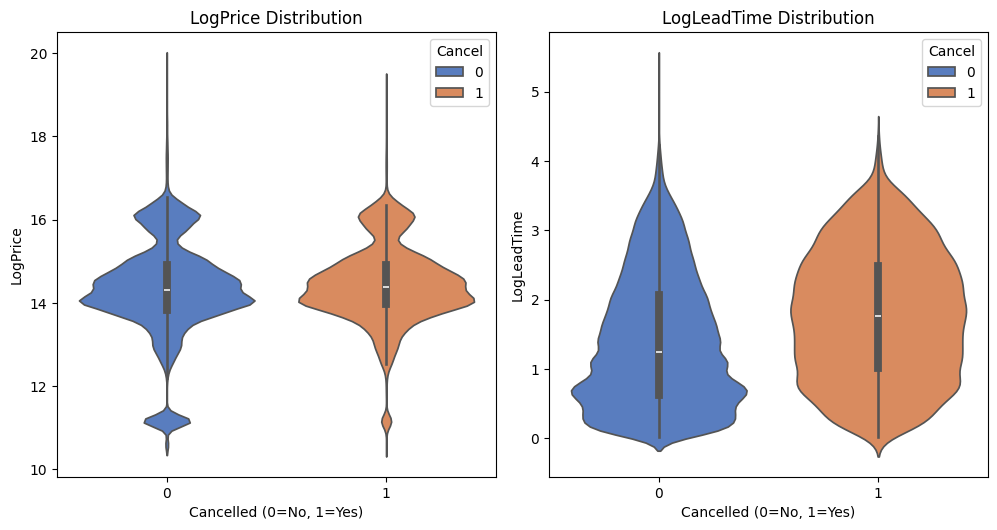

In [23]:
# STATISTICAL TEST - ENTIRE train_dfSET

print(f"{'Variable':<25} | {'P-Value':<10} | {'Effect Size (Cramer\'s V)':<25}")
print("-" * 65)

def get_cramers_v(confusion_matrix):
    """Calculate Cramer's V for a confusion matrix."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

for col in cat_vars:
    # 1. Create the Contingency Table (Cross-tabulation)
    contingency_table = pd.crosstab(train_df[col], train_df[target])
    
    # 2. Run Chi-Squared Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # 3. Calculate Strength (Cramer's V)
    strength = get_cramers_v(contingency_table)
    
    # 4. Print results
    # We flag "Statistically Significant" if p < 0.05
    sig_flag = "(*)" if p < 0.05 else ""
    print(f"{col:<25} | {p:.4f} {sig_flag:<3} | {strength:.4f}")

print("\n(*) = Statistically Significant (p < 0.05)")
print("Note: If P is low but V is low (< 0.1), the variable is 'Significant' but WEAK.")

# ==========================================
# 3. VISUAL SEPARABILITY TEST (VIOLIN PLOTS)
# ==========================================
# We plot numerical variables to see if the shapes for "0" and "1" are different.

plt.figure(figsize=(15, 10))

for i, col in enumerate(num_vars):
    plt.subplot(2, 3, i + 1) # Adjust grid size (2 rows, 3 cols) based on num_vars count
    
    # Violin plot shows the density (shape) of train_df
    sns.violinplot(x=target, y=col, data=train_df, palette="muted", hue=target, split=False)
    
    plt.title(f"{col} Distribution")
    plt.xlabel("Cancelled (0=No, 1=Yes)")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [24]:
from scipy.stats import mannwhitneyu

print(f"\n{'Numerical Variable':<25} | {'P-Value':<10} | {'Effect Size (Cohen\'s d)':<25}")
print("-" * 65)

for col in num_vars:
    # Split data by target
    group_0 = train_df[train_df[target] == 0][col].dropna()
    group_1 = train_df[train_df[target] == 1][col].dropna()
    
    # Mann-Whitney U test (non-parametric, safer for skewed data)
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    
    # Cohen's d for effect size
    mean_diff = group_1.mean() - group_0.mean()
    pooled_std = np.sqrt(((len(group_0)-1)*group_0.std()**2 + (len(group_1)-1)*group_1.std()**2) / (len(group_0) + len(group_1) - 2))
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
    
    sig_flag = "(*)" if p < 0.05 else ""
    print(f"{col:<25} | {p:.4f} {sig_flag:<3} | {cohens_d:.4f}")


Numerical Variable        | P-Value    | Effect Size (Cohen's d)  
-----------------------------------------------------------------
LogPrice                  | 0.0000 (*) | 0.1015
LogLeadTime               | 0.0000 (*) | 0.3877


In [25]:
print("\nClass Distribution:")
print(train_df[target].value_counts(normalize=True))


Class Distribution:
Cancel
0    0.862269
1    0.137731
Name: proportion, dtype: float64


In [26]:
from scipy.stats import contingency

# For categorical variables
for i, col1 in enumerate(cat_vars):
    for col2 in cat_vars[i+1:]:
        contingency_table = pd.crosstab(train_df[col1], train_df[col2])
        v = get_cramers_v(contingency_table)
        if v > 0.7:  # High correlation
            print(f"High correlation between {col1} and {col2}: V={v:.3f}")

High correlation between Domestic and To_Encoded: V=0.820
High correlation between Domestic and Route_Encoded: V=1.000
High correlation between From_Encoded and Route_Encoded: V=1.000
High correlation between To_Encoded and Route_Encoded: V=1.000


In [27]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(train_df[cat_vars + num_vars], train_df[target], random_state=42)
mi_df = pd.DataFrame({'Feature': cat_vars + num_vars, 'MI_Score': mi_scores}).sort_values('MI_Score', ascending=False)
print("\nMutual Information Scores:")
print(mi_df)


Mutual Information Scores:
         Feature  MI_Score
8    LogLeadTime  0.067223
7       LogPrice  0.018702
0       Domestic  0.012626
1     TripReason  0.011919
6  Route_Encoded  0.010793
5     To_Encoded  0.007095
4   From_Encoded  0.006547
3      TimeOfDay  0.004816
2        Vehicle  0.003988
